In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.timeseries import LombScargle
import seaborn; seaborn.set()

# for audio
import math
import random
from IPython.display import IFrame
from IPython.display import DisplayObject
from IPython.core.display import display

# for interactive plot
import ipywidgets as widgets

%matplotlib inline

# Read data and set times from initial observation (Run this cell to load data)

In [2]:
df = pd.read_csv('psr_b0329_54_cleaned.csv')
time = df.UTC - df.UTC[0]
df.head()


,Unnamed: 0,UTC,RA,DEC,AZ,EL,YY1,XX1,CAL,Sweep1,Sweep2,TimeDiff,XXmean,YYmean,XXnormalized,YYnormalized
0,115,41253.440902,3.55531,54.5797,312.195,53.5884,43.5317,35.9720,0,0,0,0.020971,35.994220,43.565107,-0.000617,-0.000767
1,116,41253.461874,3.55532,54.5797,312.195,53.5884,43.5668,35.9613,0,0,0,0.020972,35.984153,43.545127,-0.000635,0.000498
2,117,41253.482845,3.55533,54.5797,312.195,53.5884,43.5558,35.9740,0,0,0,0.020971,35.987153,43.544880,-0.000366,0.000251
3,118,41253.503817,3.55533,54.5797,312.195,53.5884,43.5474,35.9066,0,0,0,0.020972,35.978453,43.542080,-0.001997,0.000122
4,119,41253.524788,3.55533,54.5797,312.195,53.5884,43.5604,35.9162,0,0,0,0.020971,35.970693,43.541600,-0.001515,0.000432


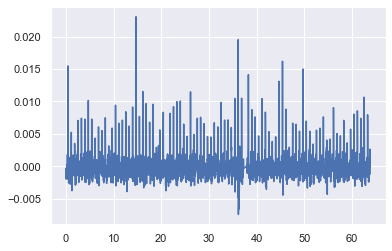

In [4]:
plt.plot(time,df.XXnormalized)

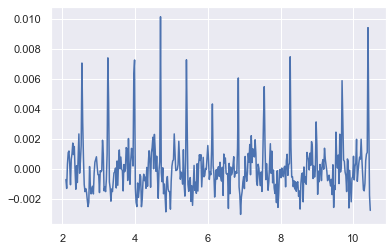

In [5]:
# pick out 5 seconds
short_time = time[100:500]
short_normalized = df.XXnormalized[100:500]
plt.plot(short_time, short_normalized)

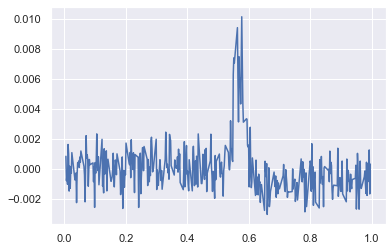

each note will play for  0.0125  seconds


In [102]:
# format and make the audio

audio_data = df.XXnormalized[100:500].to_numpy()
audio_time = time[100:500].to_numpy()
phase = (audio_time * 1.4) % 1

#print(phase[0:10])
# sort both arrays
phase, audio_data = zip(*sorted(zip(phase, audio_data)))

#print(phase[0:10])

mintemp = min(audio_data)
maxtemp = max(audio_data)

%matplotlib inline
plt.plot(phase, audio_data)
plt.show()

data = []
n = 5 #max(phase) - min(phase) #int(input('for how many seconds do you want your sequence to play? '))
dur = n/len(audio_data)
print('each note will play for ',dur,' seconds')
mn = 200 #int(input('enter minimum frequency: '))
mx = 700 #int(input('enter maximum fequency: '))
for t in np.arange(1, n, 1/44100):
    temp_index = int(np.floor(t/n * len(audio_data)))
    ratio = (audio_data[temp_index] - mintemp)/(maxtemp - mintemp)
    data.append(make_tone(t, ratio * mx + mn)) 

In [93]:

Audio(data, rate=44100)

# interactive plot here (run this after loading the data and defining the functions below)

<IPython.core.display.Javascript object>


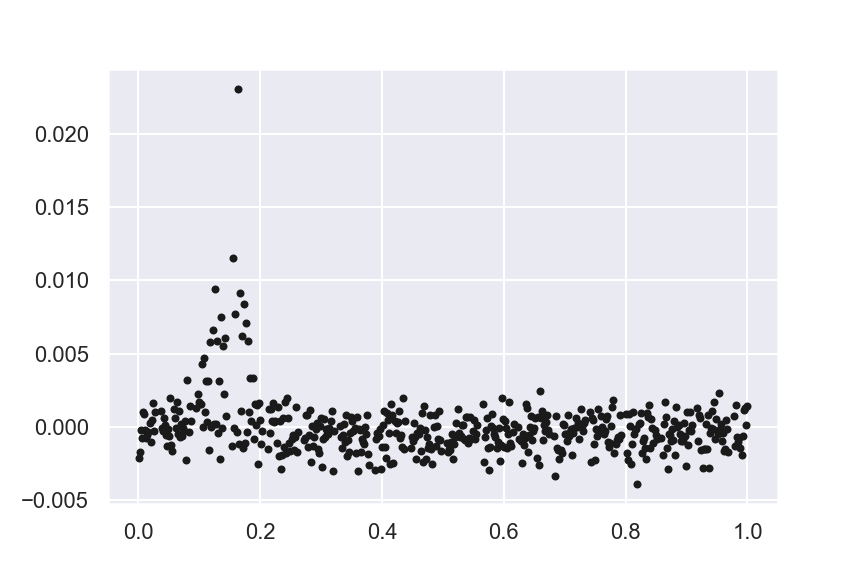

interactive(children=(FloatSlider(value=2.0, description='f', max=3.0, min=1.0), Output()), _dom_classes=('wid…

<function __main__.update(f)>

In [6]:
%matplotlib notebook

# Select a subset of the data
min_index = 300
max_index = 800
audio_data = df.XXnormalized[min_index:max_index].to_numpy()
audio_time = time[min_index:max_index].to_numpy()

mintemp = min(audio_data)
maxtemp = max(audio_data)

# set up plot
fig,ax = plt.subplots(figsize=(6,4))
ax.grid(True)

def update(f):
    phase = (audio_time * f) % 1
    phase, audio_data2 = zip(*sorted(zip(phase, audio_data)))
    [l.remove() for l in ax.lines]
    ax.plot(phase, audio_data2, 'k.')
    
    data = []
    n = 5 #length (in seconds) audio will play. You need at least a few seconds to hear the peak
    dur = n/len(audio_data2)
    mn = 200 # minimum frequency
    mx = 800 # maximum fequency
    for t in np.arange(1, n, 1/44100):
        temp_index = int(np.floor(t/n * len(audio_data2)))
        ratio = (audio_data2[temp_index] - mintemp)/(maxtemp - mintemp)
        data.append(make_tone(t, ratio * mx + mn)) 
    display(Audio(data, rate=44100))
    
widgets.interact(update, f=(1.0,3.0,0.1,))


# Functions for audio. Run this cell

In [3]:
#more import for audio
# from https://jupyter.brynmawr.edu/services/public/dblank/jupyter.cs/Sonification/putting%20it%20all%20together%20with%20sound%20version%202.ipynb

#define for audio
def make_tone(t, frequency):
    return math.sin(2 * math.pi * frequency * t)


class Audio(DisplayObject):
    _read_flags = 'rb'
    
    def __init__(self, data=None, filename=None, url=None, embed=None, rate=None, autoplay=False, maxvalue=None):
        if filename is None and url is None and data is None:
            raise ValueError("No image data found. Expecting filename, url, or data.")
        if embed is False and url is None:
            raise ValueError("No url found. Expecting url when embed=False")

        if url is not None and embed is not True:
            self.embed = False
        else:
            self.embed = True
        self.autoplay = autoplay
        self.maxvalue = maxvalue
        super(Audio, self).__init__(data=data, url=url, filename=filename)

        if self.data is not None and not isinstance(self.data, bytes):
            self.data = self._make_wav(data,rate)

    def reload(self):
        """Reload the raw data from file or URL."""
        import mimetypes
        if self.embed:
            super(Audio, self).reload()

        if self.filename is not None:
            self.mimetype = mimetypes.guess_type(self.filename)[0]
        elif self.url is not None:
            self.mimetype = mimetypes.guess_type(self.url)[0]
        else:
            self.mimetype = "audio/wav"

    def _make_wav(self, data, rate):
        """ Transform a numpy array to a PCM bytestring """
        import struct
        from io import BytesIO
        import wave

        try:
            import numpy as np

            data = np.array(data, dtype=float)
            if len(data.shape) == 1:
                nchan = 1
            elif len(data.shape) == 2:
                # In wave files,channels are interleaved. E.g.,
                # "L1R1L2R2..." for stereo. See
                # http://msdn.microsoft.com/en-us/library/windows/hardware/dn653308(v=vs.85).aspx
                # for channel ordering
                nchan = data.shape[0]
                data = data.T.ravel()
            else:
                raise ValueError('Array audio input must be a 1D or 2D array')
            if self.maxvalue is None:
                maxvalue = np.max(np.abs(data))
            else:
                maxvalue = self.maxvalue
            scaled = np.int16(data/maxvalue * 32767).tolist()
        except ImportError:
            # check that it is a "1D" list
            idata = iter(data)  # fails if not an iterable
            try:
                iter(idata.next())
                raise TypeError('Only lists of mono audio are '
                    'supported if numpy is not installed')
            except TypeError:
                # this means it's not a nested list, which is what we want
                pass
            if self.maxvalue is None:
                maxvalue = float(max([abs(x) for x in data]))
            else:
                maxvalue = self.maxvalue
            scaled = [int(x/maxvalue * 32767) for x in data]
            nchan = 1

        fp = BytesIO()
        waveobj = wave.open(fp,mode='wb')
        waveobj.setnchannels(nchan)
        waveobj.setframerate(rate)
        waveobj.setsampwidth(2)
        waveobj.setcomptype('NONE','NONE')
        waveobj.writeframes(b''.join([struct.pack('<h',x) for x in scaled]))
        val = fp.getvalue()
        waveobj.close()
        return val

    def _data_and_metadata(self):
        """shortcut for returning metadata with url information, if defined"""
        md = {}
        if self.url:
            md['url'] = self.url
        if md:
            return self.data, md
        else:
            return self.data

    def _repr_html_(self):
        src = """
                <audio controls="controls" {autoplay}>
                    <source src="{src}" type="{type}" />
                    Your browser does not support the audio element.
                </audio>
              """
        return src.format(src=self.src_attr(),type=self.mimetype, autoplay=self.autoplay_attr())

    def src_attr(self):
        import base64
        if self.embed and (self.data is not None):
            data = base64=base64.b64encode(self.data).decode('ascii')
            return """data:{type};base64,{base64}""".format(type=self.mimetype,
                                                            base64=data)
        elif self.url is not None:
            return self.url
        else:
            return ""

    def autoplay_attr(self):
        if(self.autoplay):
            return 'autoplay="autoplay"'
        else:
            return ''
        
print("This cell defines the Audio class.")

This cell defines the Audio class.
